In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
import os
import time
import datetime

In [7]:
import pyroutelib3
from pyroutelib3 import Router
import requests, json
import urllib.parse
import tempfile
import zipfile

In [8]:
import tkinter as tk
from tkinter import simpledialog
from tkinter import messagebox
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# I) Les vélos en libre-service 

### Velib - disponibilité en temps réel

Données disponibles au lien suivant : 
https://smartregionidf.opendatasoft.com/explore/dataset/velib-disponibilite-en-temps-reel/export/?disjunctive.name&disjunctive.is_installed&disjunctive.is_renting&disjunctive.is_returning&disjunctive.nom_arrondissement_communes

In [13]:
velib = gpd.read_file("https://smartregionidf.opendatasoft.com/explore/dataset/velib-disponibilite-en-temps-reel/download/?format=geojson&timezone=Europe/Berlin&lang=fr")

### Cristolib et Vélo2 en libre-service à Créteil

Données disponibles aux liens suivants : 
- https://smartregionidf.opendatasoft.com/explore/dataset/jcdecaux-bike-stations-data/information/


In [11]:
velos2 = gpd.read_file('https://smartregionidf.opendatasoft.com/explore/dataset/jcdecaux-bike-stations-data/download/?format=geojson&timezone=Europe/Berlin&lang=fr')

### Veligo

Données disponibles au lien suivant : https://smartregionidf.opendatasoft.com/explore/dataset/points-de-contact-veligo-location/information/

In [12]:
veligo = gpd.read_file('https://smartregionidf.opendatasoft.com/explore/dataset/points-de-contact-veligo-location/download/?format=geojson&timezone=Europe/Berlin&lang=fr')

### Fusion des bases de données Vélib, Veligo et Velos2

In [14]:
#Ajout d'une colonne correspondant au type du vélo (vélib, véligo ou vélos2)

velib["type"]=["velib" for i in range(velib.shape[0])]
veligo["type"]=["veligo" for i in range(veligo.shape[0])]
velos2["type"]=["velos2" for i in range(velos2.shape[0])]

In [15]:
# Ajout d'une colonne disponibilité vélos pour ceux qui n'en ont pas

veligo["numbikesavailable"]=["N" for i in range(veligo.shape[0])]

#velib["numbikesavailable"][1:velib.shape[0]]=[0 for i in range(1, velib.shape[0])]

#velos2["available_bikes"]=[0 for i in range(velos2.shape[0])]

# Ajout d'une colonne disponibilité docks pour ceux qui n'en ont pas 

veligo["numdocksavailable"]=["N" for i in range(veligo.shape[0])]

In [16]:
# Selectionner et renommer les colonnes de chaque base

velib = velib[["name","geometry","type", "numbikesavailable", "numdocksavailable"]]

veligo = veligo [["nom","geometry","type","numbikesavailable", "numdocksavailable"]]
veligo.columns = ['name','geometry',"type","numbikesavailable", "numdocksavailable"]

velos2 = velos2 [["name", "geometry","type","available_bikes", "available_bike_stands"]]
velos2.columns = ['name','geometry',"type","numbikesavailable", "numdocksavailable"]

In [17]:
velos = pd.concat([veligo, velib, velos2], ignore_index=True)

In [18]:
velos.shape

(2530, 5)

In [19]:
velos.shape[0] ==  veligo.shape[0] + velib.shape[0] + velos2.shape[0] 

True

In [20]:
velos

,name,geometry,type,numbikesavailable,numdocksavailable
0,ST MAUR DES FOSSES PDC,POINT (2.49129 48.80253),veligo,N,N
1,BRY PPDC1,POINT (2.52455 48.82955),veligo,N,N
2,CRETEIL PPDC1,POINT (2.45490 48.77790),veligo,N,N
3,FONTENAY SOUS BOIS PDC1,POINT (2.47531 48.84936),veligo,N,N
4,IVRY PDC1,POINT (2.40150 48.80670),veligo,N,N
...,...,...,...,...,...
2525,50005 - CER05 - MOULIN A VENT,POINT (2.01708 49.04940),velos2,3,17
2526,50009 - CER09 - RUE DU BRÛLOIR,POINT (2.07718 49.02724),velos2,2,9
2527,50015 - CER15 - PLACE DES LINANDES (CB),POINT (2.06893 49.04328),velos2,6,12
2528,10 - MAGELLAN,POINT (2.45666 48.76896),velos2,6,14


In [21]:
departements = gpd.read_file('https://www.data.gouv.fr/fr/datasets/r/ec305e78-f231-4a77-b32c-1e0c4c67615e')
dpt = departements[departements['code_departement'].isin(['75', '77', '78', '91', '92', '93', '94', '95' ])]

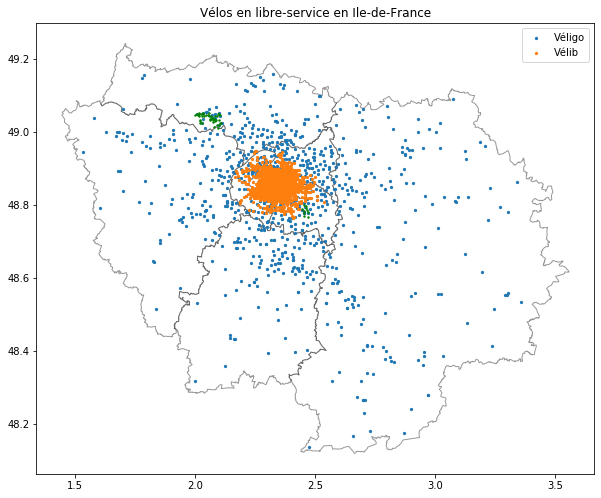

In [22]:
fig, ax = plt.subplots(figsize = (10,10))
dpt.plot(ax=ax, color = 'white', edgecolor = 'black', alpha = 0.4)

velos[velos["type"]=="veligo"].plot(ax=ax, color='tab:blue', label = 'Véligo', markersize=5)
velos[velos["type"]=="velib"].plot(ax=ax, color='tab:orange', label = 'Vélib', markersize=5)
velos[velos["type"]=="velos2"].plot(ax=ax, color='green', markersize=2)

plt.title('Vélos en libre-service en Ile-de-France')
plt.legend()
plt.show()

In [23]:
centre = [48.8534 , 2.3488] #Centre de paris 
idf = folium.Map(location = centre, zoom_start = 13)
idf

# II] Utilisation du GPS 

## Choix du point de départ et du point d'arrivée

In [2]:
adresse_depart =input("D'où partez-vous ? (numéro, rue, code postal ville)")

adresse_arrivee = input("Où voulez-vous aller ? (numéro, rue, code postal ville)")

D'où partez-vous ? (numéro, rue, code postal ville) 5, Avenue Anatole France, 75007 Paris
Où voulez-vous aller ? (numéro, rue, code postal ville) 1, Rue de Rivoli, 75001 Paris


In [3]:
print(adresse_depart)

5, Avenue Anatole France, 75007 Paris


In [4]:
print(adresse_arrivee)

1, Rue de Rivoli, 75001 Paris


In [24]:
#adresse_depart = "5, Avenue Anatole France, 75007 Paris"
#adresse_arrivee = "1, Rue de Rivoli, 75001 Paris"
dep_json = requests.get("https://api-adresse.data.gouv.fr/search/?q=" + urllib.parse.quote(adresse_depart) + "&format=json").json()
arr_json = requests.get("https://api-adresse.data.gouv.fr/search/?q=" + urllib.parse.quote(adresse_arrivee) + "&format=json").json()
coord_dep = list(dep_json['features'][0].get('geometry').get('coordinates'))
coord_arr = list(arr_json['features'][0].get('geometry').get('coordinates'))

In [26]:
x = input("Avez-vous votre propre vélo ? Entrez 'oui' ou 'non' ")

Avez-vous votre propre vélo ? Entrez 'oui' ou 'non'  non


## Lorsque l'utilisateur n'a pas son propre vélo

In [28]:
if(x=='non'):
                                                                                 
    coor_depart = [coord_dep[1], coord_dep[0]] 
    coor_arrivee = [coord_arr[1], coord_arr[0]] 
    
    # Ré-initialisation de la carte 
    centre = coor_depart 
    idf = folium.Map(location = centre, zoom_start = 13)
    
    # Calcul de la distance en km entre le point de départ et toutes les stations

    distances = []
    for i in range(len(velos.geometry)):
      a = (max(velos.geometry[i].x, coord_dep[0]) - min(velos.geometry[i].x, coord_dep[0]))**2 + (max(velos.geometry[i].y, coord_dep[1]) - min(velos.geometry[i].y, coord_dep[1]))**2
      a = a**(1/2)*100
      distances.append(a)
    
    #Station la plus proche du point de départ 

    i = distances.index(min(distances))

    station_dep = [velos["geometry"][i].y, velos["geometry"][i].x]

    print( 'Station la plus proche du point de départ :', velos["name"][i] )
    
    
    # Vérification disponibilité vélo dans la station de départ
    
    if(velos["numbikesavailable"][i]!="0" and velos["numbikesavailable"][i]!="N" ):
        print("\n \n Un vélo est disponible à la station la plus proche du point de départ")
        
    elif(velos["numbikesavailable"][i]=="N"):
        print("\n \n Nous ne disposons pas d'information concernant la disponibilité d'un vélo à la station la plus proche du point de départ")
        
    elif(velos["numbikesavailable"][i]=="0"):
        print("\n \n Pas de vélo disponible à la station la plus proche du point de départ")

        k = i
        
        while( velos["numbikesavailable"][k]=="0"):
            
            # Nouvelle station la plus proche et avec vélo disponible

            distances.pop(k)
            k = distances.index(min(distances))

            station_dep = [velos["geometry"][k].y, velos["geometry"][k].x]

        print( 'Station la plus proche du point de départ avec vélo disponible : \n', velos["name"][k] )
          
    
    print('\n \nDistance à effectuer à pied (point de départ -> station de départ) :', round(min(distances),2), "km")
    print("soit un temps de trajet d'environ :", round(min(distances)*1000/66.67), "minutes\n \n")
    
    t = min(distances)*1000/66.67
        
    
    # Calcul de la distance en km entre le point d'arrivée et toutes les stations

    distances = []
    for i in range(len(velos.geometry)):
      a = (max(velos.geometry[i].x, coord_arr[0]) - min(velos.geometry[i].x, coord_arr[0]))**2 + (max(velos.geometry[i].y, coord_arr[1]) - min(velos.geometry[i].y, coord_arr[1]))**2
      a = a**(1/2)*100
      distances.append(a)
    
    #Station la plus proche du point d'arrivée

    j = distances.index(min(distances))

    station_arr = [velos["geometry"][j].y, velos["geometry"][j].x] 
    
    print( 'Station la plus proche du point d arrivée : ', velos["name"][j] )
    
    # Vérification disponibilité dock dans la station d'arrivée
    
    if(velos["numdocksavailable"][j]!="0" and velos["numdocksavailable"][j]!="N" ):
        print("\n Un dock est disponible à la station la plus proche du point d'arrivée")
    
    elif(velos["numdocksavailable"][j]=="N"):
        print("\nNous ne disposons pas d'information concernant la disponibilité d'un dock à la station la plus proche du point d'arrivée")
    
    elif(velos["numdocksavailable"][j]=="0"):
        print("\nPas de dock disponible à la station la plus proche du point d'arrivée'")
        
        while( velos["numdocksavailable"][j]=="0"):
            
            # Nouvelle station la plus proche et avec dock disponible

            distances.pop(j)
            j = distances.index(min(distances))

            station_arr = [velos["geometry"][j].y, velos["geometry"][j].x]

        print( "Station la plus proche du point d'arrivée avec dock disponible : \n", velos["name"][k] )
        
    # Durée et distance trajet à vélo
    
    d = (max(station_dep[0], station_arr[0]) - min(station_dep[0], station_arr[0]))**2 + (max(station_dep[1], station_arr[1]) - min(station_dep[1], station_arr[1]))**2
    d = d**(1/2)*100                                                                                                 

    print( '\n \nDistance à effectuer en vélo (station de départ -> station d\'arrivée) :', round(d,2), "km")
    print("soit un temps de trajet d'environ :", round(d*1000/250), "minutes\n")
    print( '\n Distance à effectuer à pied (station d\'arrivée -> point d\'arrivée) :', round(min(distances),2), "km")
    print("soit un temps de trajet d'environ :", round(min(distances)*1000/66.67), "minutes\n \n")
    
    print("Le temps total du trajet est donc de :", round(t+d*1000/250+min(distances)*1000/66.67)  ,"minutes\n \n")
    
    # Si le temps total du trajet calculé > temps de trajet en faisant tout à pied, alors faire le trajet à pied 
    
    d_pied = (max(coord_dep[0], coord_arr[0]) - min(coord_dep[0], coord_arr[0]))**2 + (max(coord_dep[1], coord_arr[1]) - min(coord_dep[1], coord_arr[1]))**2
    d_pied = d_pied**(1/2)*100
    t_pied = d_pied*1000/66.67
    
    if( t+d*1000/250+min(distances)*1000/66.67 > t_pied ):
        
        print("ATTENTION : Il serait plus judicieux de faire tout le trajet à pied car :")
        print("Distance du point de départ au point d'arrivée :", round(d_pied,2), "km")
        print("Temps du trajet à pied :", round(t_pied), "minutes\n" )
            
    #Trajet à pied : point de départ -> station départ

    folium.Marker(coor_depart,popup="Depart").add_to(idf)
    folium.Marker(coor_arrivee,popup="Arrivee").add_to(idf)
    
    router = pyroutelib3.Router("foot")

    depart = router.findNode(coor_depart[0], coor_depart[1])
    arrivee = router.findNode(station_dep[0], station_dep[1])

    routeLatLons=[coor_depart,station_dep]
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
      #print("votre trajet existe")
      routeLatLons = list(map(router.nodeLatLon, route))
    else:
      print("Votre trajet n'existe pas")

    #print(routeLatLons)
    for coord in routeLatLons:
      coord=list(coord)
      folium.CircleMarker(coord,radius = 3,fill=True, color='green').add_to(idf)

    folium.PolyLine(routeLatLons, color="black", weight=2.5, opacity=1).add_to(idf)
    
    # Trajet en vélo : station départ -> station arrivée
    
    router = pyroutelib3.Router("cycle")
    depart = router.findNode(station_dep[0], station_dep[1])
    arrivee = router.findNode(station_arr[0], station_arr[1])

    routeLatLons=[station_dep,station_arr]
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
      #print("votre trajet existe")
      routeLatLons = list(map(router.nodeLatLon, route))
    else:
      print("votre trajet n'existe pas")

    #print(routeLatLons)
    for coord in routeLatLons:
      coord=list(coord)
      folium.CircleMarker(coord,radius = 3,fill=True, color='green').add_to(idf)

    folium.PolyLine(routeLatLons, color="red", weight=2.5, opacity=1).add_to(idf)
    
    
    # Trajet à pied : station arrivée -> point d'arrivée
    
    router = pyroutelib3.Router("foot")
    depart = router.findNode(station_arr[0], station_arr[1])
    arrivee = router.findNode(coor_arrivee[0], coor_arrivee[1])

    routeLatLons=[station_arr, coor_arrivee]
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
      #print("votre trajet existe")
      routeLatLons = list(map(router.nodeLatLon, route))
    else:
      print("Votre trajet n'existe pas")

    for coord in routeLatLons:
      coord=list(coord)
      folium.CircleMarker(coord,radius = 3,fill=True, color='green').add_to(idf)

    folium.PolyLine(routeLatLons, color="black", weight=2.5, opacity=1).add_to(idf)
    
     # Affichage des lieux accidentogènes situés à moins de 50 mètres du trajet 

    centroids = pd.read_csv("centroids_df.csv")

    dist_centroids = []
    centroids_50 = []

    for i in range( centroids.shape[0]) : 
        for k in routeLatLons : 
            dist = (k[0]- centroids["lat"][i] )**2 + (k[1]- centroids["lon"][i] )**2
            dist = dist**1/2*100
            if dist < 0.005 :
                dist_centroids.append(dist)
                centroids_50.append([centroids["lat"][i], centroids["lon"][i]])

    for i in range(len(centroids_50)) : 
        coord = centroids_50[i]
        folium.Marker(coord,popup="Lieu accidentogène",icon=folium.Icon(color='red', icon='info-sign')).add_to(idf)
    
    

Station la plus proche du point de départ : Bourdonnais - Tour Eiffel

 
 Un vélo est disponible à la station la plus proche du point de départ

 
Distance à effectuer à pied (point de départ -> station de départ) : 0.23 km
soit un temps de trajet d'environ : 3 minutes
 

Station la plus proche du point d arrivée :  Saint-Honoré - Musée du Louvre

 Un dock est disponible à la station la plus proche du point d'arrivée

 
Distance à effectuer en vélo (station de départ -> station d'arrivée) : 3.94 km
soit un temps de trajet d'environ : 16 minutes


 Distance à effectuer à pied (station d'arrivée -> point d'arrivée) : 0.13 km
soit un temps de trajet d'environ : 2 minutes
 

Le temps total du trajet est donc de : 21 minutes
 



In [37]:
idf

# Lorsque l'utilisateur a son propre vélo

In [35]:
if(x=='oui'):
    
    coor_depart = [coord_dep[1], coord_dep[0]] 
    coor_arrivee = [coord_arr[1], coord_arr[0]] 
    
    # Ré-initialisation de la carte 
    centre = coor_depart 
    idf = folium.Map(location = centre, zoom_start = 13)

    folium.Marker(coor_depart,popup="Depart").add_to(idf)
    folium.Marker(coor_arrivee,popup="Arrivee").add_to(idf)
    
    # Trajet en vélo : point départ -> point d'arrivée
    
    router = pyroutelib3.Router("cycle")
    depart = router.findNode(coor_depart[0], coor_depart[1])
    #print(depart)
    arrivee = router.findNode(coor_arrivee[0], coor_arrivee[1])
    #print(arrivee)

    routeLatLons=[coor_depart,coor_arrivee]
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
      #print("Votre trajet existe")
      routeLatLons = list(map(router.nodeLatLon, route))
    else:
      print("Votre trajet n'existe pas")

    #print(routeLatLons)
    for coord in routeLatLons:
      coord=list(coord)
      folium.CircleMarker(coord,radius = 3,fill=True, color='green').add_to(idf)

    folium.PolyLine(routeLatLons, color="red", weight=2.5, opacity=1).add_to(idf)
    
    # Affichage des clusters situés à moins de 50 mètres du trajet 

    centroids = pd.read_csv("centroids_df.csv")

    dist_centroids = []
    centroids_50 = []

    for i in range( centroids.shape[0]) : 
        for k in routeLatLons : 
            dist = (k[0]- centroids["lat"][i] )**2 + (k[1]- centroids["lon"][i] )**2
            dist = dist**1/2*100
            if dist < 0.005 :
                dist_centroids.append(dist)
                centroids_50.append([centroids["lat"][i], centroids["lon"][i]])

    for i in range(len(centroids_50)) : 
        coord = centroids_50[i]
        folium.Marker(coord,popup="Lieu accidentogène",icon=folium.Icon(color='red', icon='info-sign')).add_to(idf)
    

In [36]:
idf

## Signalement de la part de l'utilisateur après le trajet

In [33]:
a=input("Suite à votre trajet, souhaitez-vous signaler quelque chose ? Entrez 'oui' ou 'non'")

if(a=='oui'):
    x=input("Que souhaitez-vous signaler ?")
    print("Cliquez à l'endroit correspondant sur la carte")
    
print("Merci de contribuer à l'amélioration notre application!")

idf.add_child(folium.ClickForMarker(popup=x))

#idf.add_child(folium.LatLngPopup())

Suite à votre trajet, souhaitez-vous signaler quelque chose ? Entrez 'oui' ou 'non' non


Merci de contribuer à l'amélioration notre application!
